In [303]:
# Import of libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from scipy.stats import (shapiro, anderson, kstest, jarque_bera,
                         norm, lognorm, expon, gamma, t, gennorm, laplace,
                         describe)

import seaborn as sns

The paper reports that the data used was retrieved from Yahoo Finance [16], covering 17 years of S&P 500 stock prices from January 2001 to December 2018.

In [304]:
# Define the start date and the end date for the data analysis or time series
start_date = '2001-01-01'
end_date = '2018-12-31'

In [305]:
# Download monthly S&P 500 data from Yahoo Finance
sp500 = yf.download('^GSPC', start=start_date, end=end_date, interval='1mo')

[*********************100%***********************]  1 of 1 completed


In [306]:
# Display the first 5 rows of the S&P 500 dataset
sp500.head()

Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2001-01-01,1366.010010,1383.369995,1274.619995,1320.280029,27829800000
2001-02-01,1239.939941,1376.380005,1215.439941,1366.010010,21644400000
2001-03-01,1160.329956,1267.420044,1081.189941,1239.939941,27806610000
2001-04-01,1249.459961,1269.300049,1091.989990,1160.329956,25409990000
2001-05-01,1255.819946,1315.930054,1232.000000,1249.459961,24525900000


In [307]:
# Show column names of the S&P 500 dataset
sp500.columns

MultiIndex([( 'Close', '^GSPC'),
            (  'High', '^GSPC'),
            (   'Low', '^GSPC'),
            (  'Open', '^GSPC'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])

In [308]:
# Flatten the MultiIndex columns into  a single level
sp500.columns = ['_'.join(col).strip() for col in sp500.columns.values]

In [309]:
# Show first 5 rows of the S&P 500 data
sp500.head()

,Close_^GSPC,High_^GSPC,Low_^GSPC,Open_^GSPC,Volume_^GSPC
Date,,,,,
2001-01-01,1366.010010,1383.369995,1274.619995,1320.280029,27829800000
2001-02-01,1239.939941,1376.380005,1215.439941,1366.010010,21644400000
2001-03-01,1160.329956,1267.420044,1081.189941,1239.939941,27806610000
2001-04-01,1249.459961,1269.300049,1091.989990,1160.329956,25409990000
2001-05-01,1255.819946,1315.930054,1232.000000,1249.459961,24525900000


In [310]:
# Show column names of the S&P 500 dataset
sp500.columns

Index(['Close_^GSPC', 'High_^GSPC', 'Low_^GSPC', 'Open_^GSPC', 'Volume_^GSPC'], dtype='object')

In [311]:
# Reset the index  to default
sp500 = sp500.reset_index()

# Conver 'Date' column to datetime format
sp500['Date']=pd.to_datetime(sp500['Date'])

In [312]:
# Show the first 5 rows of the S&P 500 dataset
sp500.head()

,Date,Close_^GSPC,High_^GSPC,Low_^GSPC,Open_^GSPC,Volume_^GSPC
0,2001-01-01,1366.010010,1383.369995,1274.619995,1320.280029,27829800000
1,2001-02-01,1239.939941,1376.380005,1215.439941,1366.010010,21644400000
2,2001-03-01,1160.329956,1267.420044,1081.189941,1239.939941,27806610000
3,2001-04-01,1249.459961,1269.300049,1091.989990,1160.329956,25409990000
4,2001-05-01,1255.819946,1315.930054,1232.000000,1249.459961,24525900000


In [313]:
# Rename columns: keep 'Date' for the first column and remove ticker symbol from all other columns
sp500.columns = ['Date'] + [col.split('_')[0] for col in sp500.columns[1:]]

In [314]:
# Display the last 5 rows of the S&P 500 dataset
sp500.tail()

,Date,Close,High,Low,Open,Volume
211,2018-08-01,2901.520020,2916.500000,2796.340088,2821.169922,69523070000
212,2018-09-01,2913.979980,2940.909912,2864.120117,2896.959961,63031510000
213,2018-10-01,2711.739990,2939.860107,2603.540039,2926.290039,91930980000
214,2018-11-01,2760.169922,2815.149902,2631.090088,2717.580078,80620020000
215,2018-12-01,2506.850098,2800.179932,2346.580078,2790.500000,84162180000


 The paper states that the dataset includes a total of 216 monthly observations.

In [315]:
# Save the S&P 500 data to a CSV file named 'train.csv' without the index column
sp500.to_csv('train.csv', index=False)

In [316]:
# Get the dimensions (rows, columns) of the S&P 500 dataset
sp500.shape

(216, 6)

We observe that our dataset contains 216 months, which aligns with the data reported in the paper.

In [317]:
# Calculate the first-order difference of the 'Close' prices
sp500['close_diff'] = sp500['Close'].diff()

In [318]:
# Display the first 5 rows of the updated dataset with 'close_diff'
sp500.head()

,Date,Close,High,Low,Open,Volume,close_diff
0,2001-01-01,1366.010010,1383.369995,1274.619995,1320.280029,27829800000,NaN
1,2001-02-01,1239.939941,1376.380005,1215.439941,1366.010010,21644400000,-126.070068
2,2001-03-01,1160.329956,1267.420044,1081.189941,1239.939941,27806610000,-79.609985
3,2001-04-01,1249.459961,1269.300049,1091.989990,1160.329956,25409990000,89.130005
4,2001-05-01,1255.819946,1315.930054,1232.000000,1249.459961,24525900000,6.359985


In [319]:
# Split the dataset into training data up to December 31, 2017
train = sp500.loc[:'2017-12-31']

# Split the dataset into test data from January 1, 2018 onward
test = sp500.loc['2018-01-01':]

In [320]:
# Display the number of rows and columns in the training dataset
train.shape

(202, 7)

In [321]:
# Display the number of rows and columns in the test dataset
test.shape

(14, 7)

In [322]:
# Display the full training dataset
train

,Date,Close,High,Low,Open,Volume,close_diff
0,2001-01-01,1366.010010,1383.369995,1274.619995,1320.280029,27829800000,NaN
1,2001-02-01,1239.939941,1376.380005,1215.439941,1366.010010,21644400000,-126.070068
2,2001-03-01,1160.329956,1267.420044,1081.189941,1239.939941,27806610000,-79.609985
3,2001-04-01,1249.459961,1269.300049,1091.989990,1160.329956,25409990000,89.130005
4,2001-05-01,1255.819946,1315.930054,1232.000000,1249.459961,24525900000,6.359985
...,...,...,...,...,...,...,...
197,2017-06-01,2423.409912,2453.820068,2405.699951,2415.649902,81078810000,11.609863
198,2017-07-01,2470.300049,2484.040039,2407.699951,2431.389893,63348090000,46.890137
199,2017-08-01,2471.649902,2490.870117,2417.350098,2477.100098,70784900000,1.349854
200,2017-09-01,2519.360107,2519.439941,2446.550049,2474.419922,66624120000,47.710205


In [323]:
# Display the full test dataset
test

,Date,Close,High,Low,Open,Volume,close_diff
202,2017-11-01,2647.580078,2657.739990,2557.449951,2583.209961,73416960000,72.320068
203,2017-12-01,2673.610107,2694.969971,2605.520020,2645.100098,65531700000,26.030029
204,2018-01-01,2823.810059,2872.870117,2682.360107,2683.729980,77318690000,150.199951
205,2018-02-01,2713.830078,2835.959961,2532.689941,2816.449951,79933970000,-109.979980
206,2018-03-01,2640.870117,2801.899902,2585.889893,2715.219971,76803890000,-72.959961
207,2018-04-01,2648.050049,2717.489990,2553.800049,2633.449951,70194700000,7.179932
208,2018-05-01,2705.270020,2742.239990,2594.620117,2642.959961,76011820000,57.219971
209,2018-06-01,2718.370117,2791.469971,2691.989990,2718.699951,77891360000,13.100098
210,2018-07-01,2816.290039,2848.030029,2698.949951,2704.949951,64898300000,97.919922
211,2018-08-01,2901.520020,2916.500000,2796.340088,2821.169922,69523070000,85.229980


In [324]:
# Show the shape (rows, columns) of the training dataset
train.shape

(202, 7)

In [325]:
# Show the shape (rows, columns) of the test dataset
test.shape

(14, 7)

Below there is a plot from the paper showing the S&P 500 adjusted closing price over time.

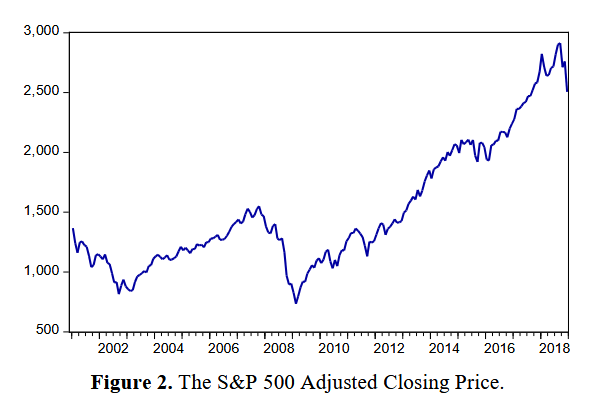

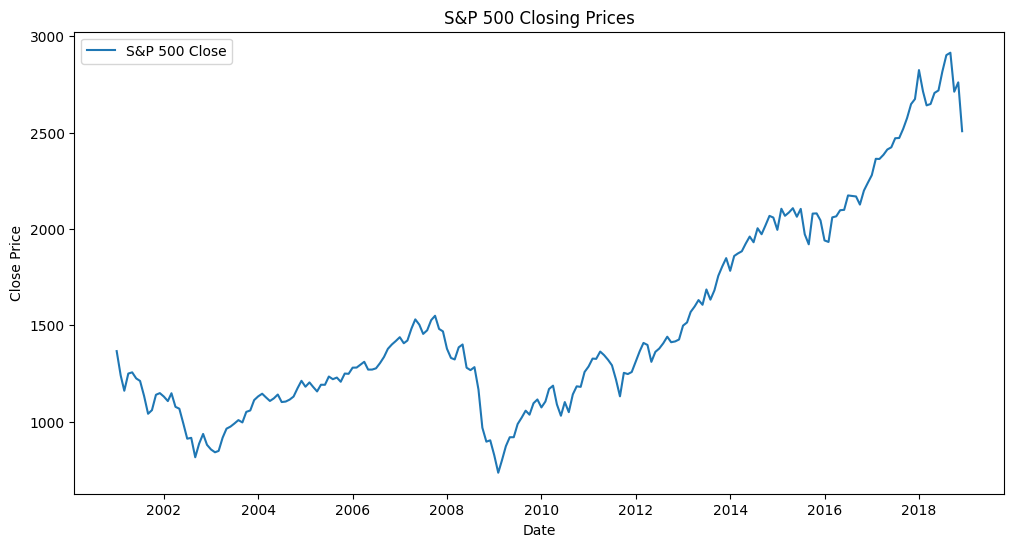

In [326]:
# Plot the S&P 500 closing prices over time
plt.figure(figsize=(12, 6))  
plt.plot(sp500['Date'], sp500['Close'], label='S&P 500 Close')  # Plot Date vs Close
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('S&P 500 Closing Prices')
plt.legend()
plt.show()

In terms of graphs we see that they plotted the whole df - sp500; not split train and test

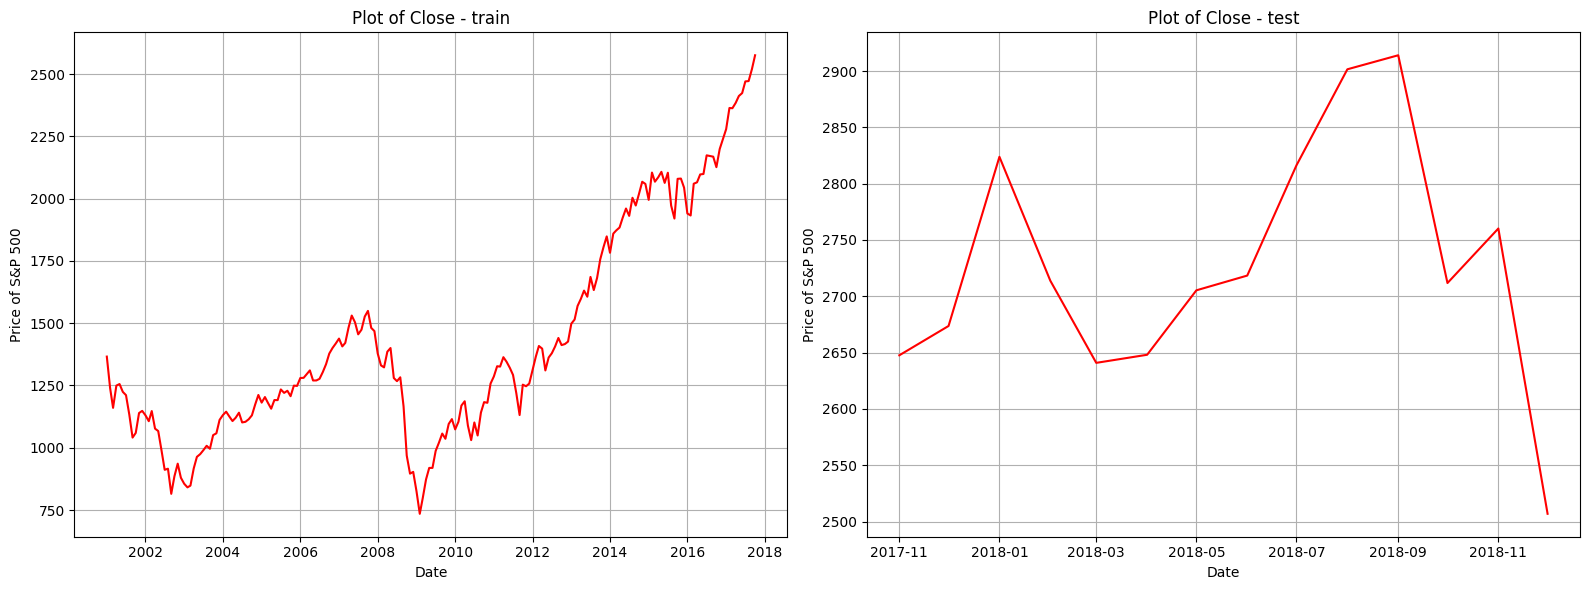

In [327]:
# Set Date as index
train.set_index('Date', inplace=True)
test.set_index('Date', inplace=True)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot train data
axs[0].plot(train.index, train['Close'], color='red')
axs[0].set_title('Plot of Close - train')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price of S&P 500')
axs[0].grid(True)

# Plot test data
axs[1].plot(test.index, test['Close'], color='red')
axs[1].set_title('Plot of Close - test')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Price of S&P 500')
axs[1].grid(True)

plt.tight_layout()
plt.show()

Below is a correlogram of the S&P 500 adjusted closing price, including ACF and PACF plots, along with related statistical tests as shown in the paper.

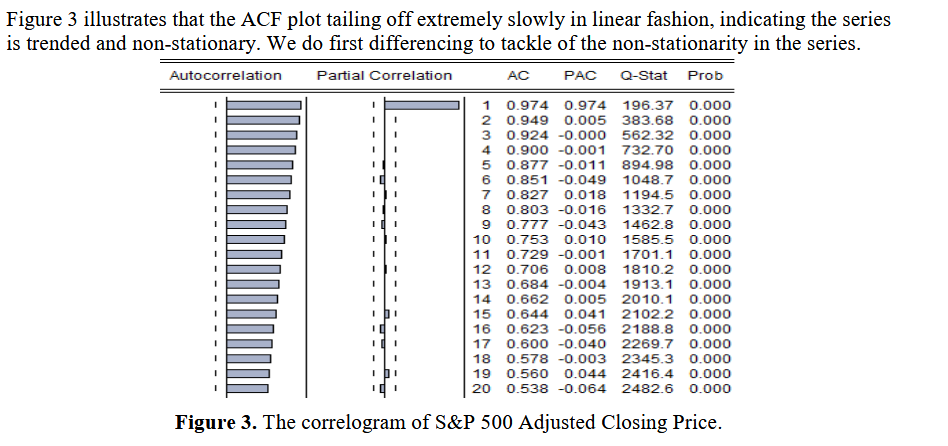

The paper does not specify whether the ACF/PACF tests were performed on the full dataset or just the training set. 

Therefore, we decided to conduct ACF, PACF, autocorrelation, partial autocorrelation, Q-statistics, and corresponding probability tests on both the full dataset and the training set. 

We excluded the test set since it contains only 14 observations.

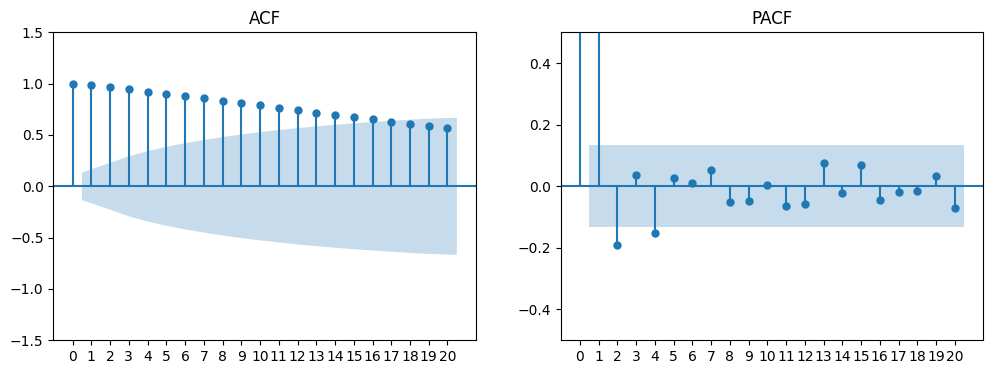

In [328]:
# Create side-by-side plots for ACF and PACF of S&P 500 Close prices
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(sp500['Close'], lags=20, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-1.5,1.5])
axes[0].set_xticks(range(0, 21, 1))

# Partial autocorrelation plot
plot_pacf(sp500['Close'], lags=20, ax=axes[1]) # PACF
axes[1].set_title("PACF")
axes[1].set_ylim([-0.5,0.5])
axes[1].set_xticks(range(0, 21, 1))

plt.show()

In [329]:
# Calculate ACF and PACF values with 95% confidence intervals
acf_values_sp500, acf_confint_sp500 = acf(sp500['Close'], nlags=20, alpha=0.05)
pacf_values_sp500, pacf_confint_sp500 = pacf(sp500['Close'], nlags=20, alpha=0.05)

# Perform Ljung-Box Q-test for autocorrelation up to lag 20
q_test_sp500 = acorr_ljungbox(sp500['Close'], lags=20, return_df=True) 

# Create a summary table similar to EViews output
results_sp500 = pd.DataFrame({
    'Lag': range(1, 21),
    'AC': acf_values_sp500[1:], # Autocorrelation (excluding lag 0)
    'PAC': pacf_values_sp500[1:],  # Partial autocorrelation (excluding lag 0)
    'Q-Stat': q_test_sp500['lb_stat'].values,
    'Prob': q_test_sp500['lb_pvalue'].values
})

# Print the summary rounded to 4 decimals
print("\nAutocorrelation Summary:")
print(results_sp500.round(4))


Autocorrelation Summary:
    Lag      AC     PAC     Q-Stat  Prob
0     1  0.9854  0.9900   212.6577   0.0
1     2  0.9654 -0.2809   417.7318   0.0
2     3  0.9458  0.0852   615.4782   0.0
3     4  0.9225 -0.2491   804.5125   0.0
4     5  0.8989  0.1037   984.8270   0.0
5     6  0.8763 -0.0254  1157.0137   0.0
6     7  0.8553  0.1209  1321.8419   0.0
7     8  0.8339 -0.1322  1479.2653   0.0
8     9  0.8112 -0.0286  1628.9594   0.0
9    10  0.7891 -0.0154  1771.2767   0.0
10   11  0.7656 -0.0869  1905.9074   0.0
11   12  0.7399 -0.0651  2032.2869   0.0
12   13  0.7163  0.1432  2151.3079   0.0
13   14  0.6933 -0.0806  2263.3541   0.0
14   15  0.6720  0.1797  2369.1463   0.0
15   16  0.6513 -0.1834  2469.0088   0.0
16   17  0.6303  0.0769  2563.0180   0.0
17   18  0.6099 -0.1323  2651.4687   0.0
18   19  0.5902  0.1928  2734.7328   0.0
19   20  0.5692 -0.2900  2812.5642   0.0


Since our results differ from those in the paper, we will run the tests on the training set.

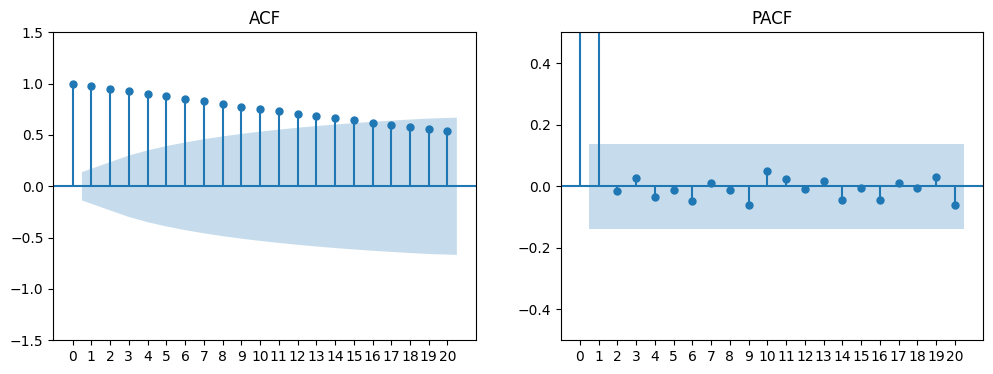

In [330]:
# Plot ACF and PACF for the training dataset's Close prices
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation function (ACF) plot
plot_acf(train['Close'], lags=20, ax=axes[0])
axes[0].set_title("ACF")
axes[0].set_ylim([-1.5,1.5])
axes[0].set_xticks(range(0, 21, 1))

# Partial autocorrelation function (PACF) plot
plot_pacf(train['Close'], lags=20, ax=axes[1])
axes[1].set_title("PACF")
axes[1].set_ylim([-0.5,0.5])
axes[1].set_xticks(range(0, 21, 1))

plt.show()

In [331]:
# Calculate ACF and PACF values with 95% confidence intervals for training data
acf_values_train, acf_confint_train = acf(train['Close'], nlags=20, alpha=0.05)
pacf_values_train, pacf_confint_train = pacf(train['Close'], nlags=20, alpha=0.05)

# Perform Ljung-Box Q-test on training data
q_test_train = acorr_ljungbox(train['Close'], lags=20, return_df=True) 

# Create summary table like EViews output for training data
results_train = pd.DataFrame({
    'Lag': range(1, 21),
    'AC': acf_values_train[1:],  # Autocorrelation, excluding lag 0
    'PAC': pacf_values_train[1:], # Partial autocorrelation, excluding lag 0
    'Q-Stat': q_test_train['lb_stat'].values,
    'Prob': q_test_train['lb_pvalue'].values
})

# Print the summary rounded to 4 decimals
print("\nAutocorrelation Summary:")
print(results_train.round(4))


Autocorrelation Summary:
    Lag      AC     PAC     Q-Stat  Prob
0     1  0.9749  0.9797   194.8331   0.0
1     2  0.9496 -0.0188   380.6137   0.0
2     3  0.9263  0.0346   558.2774   0.0
3     4  0.9019 -0.0425   727.5654   0.0
4     5  0.8775 -0.0148   888.6153   0.0
5     6  0.8514 -0.0600  1041.0184   0.0
6     7  0.8265  0.0144  1185.3841   0.0
7     8  0.8019 -0.0157  1321.9685   0.0
8     9  0.7747 -0.0771  1450.1231   0.0
9    10  0.7508  0.0665  1571.1219   0.0
10   11  0.7290  0.0316  1685.7818   0.0
11   12  0.7070 -0.0114  1794.2029   0.0
12   13  0.6864  0.0218  1896.9420   0.0
13   14  0.6642 -0.0577  1993.6548   0.0
14   15  0.6426 -0.0094  2084.6432   0.0
15   16  0.6196 -0.0595  2169.6994   0.0
16   17  0.5976  0.0186  2249.2446   0.0
17   18  0.5766 -0.0084  2323.6929   0.0
18   19  0.5574  0.0442  2393.6446   0.0
19   20  0.5357 -0.0828  2458.6099   0.0


The results are quite similar, with minor differences likely due to rounding, precision, or differences in software implementations.

In [332]:
# Overview of S&P500 dataset
sp500

,Date,Close,High,Low,Open,Volume,close_diff
0,2001-01-01,1366.010010,1383.369995,1274.619995,1320.280029,27829800000,NaN
1,2001-02-01,1239.939941,1376.380005,1215.439941,1366.010010,21644400000,-126.070068
2,2001-03-01,1160.329956,1267.420044,1081.189941,1239.939941,27806610000,-79.609985
3,2001-04-01,1249.459961,1269.300049,1091.989990,1160.329956,25409990000,89.130005
4,2001-05-01,1255.819946,1315.930054,1232.000000,1249.459961,24525900000,6.359985
...,...,...,...,...,...,...,...
211,2018-08-01,2901.520020,2916.500000,2796.340088,2821.169922,69523070000,85.229980
212,2018-09-01,2913.979980,2940.909912,2864.120117,2896.959961,63031510000,12.459961
213,2018-10-01,2711.739990,2939.860107,2603.540039,2926.290039,91930980000,-202.239990
214,2018-11-01,2760.169922,2815.149902,2631.090088,2717.580078,80620020000,48.429932


Below there is the S&P 500 series after first differencing, as shown in the paper.

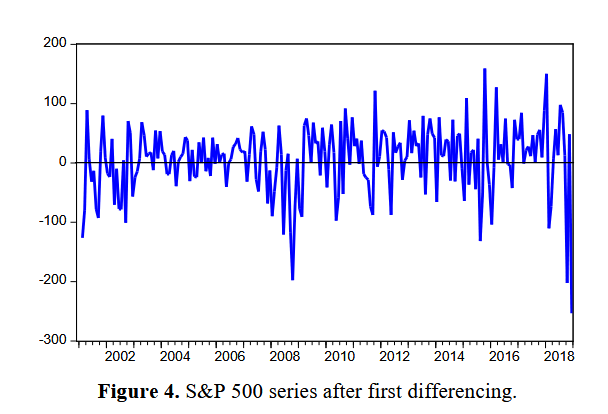

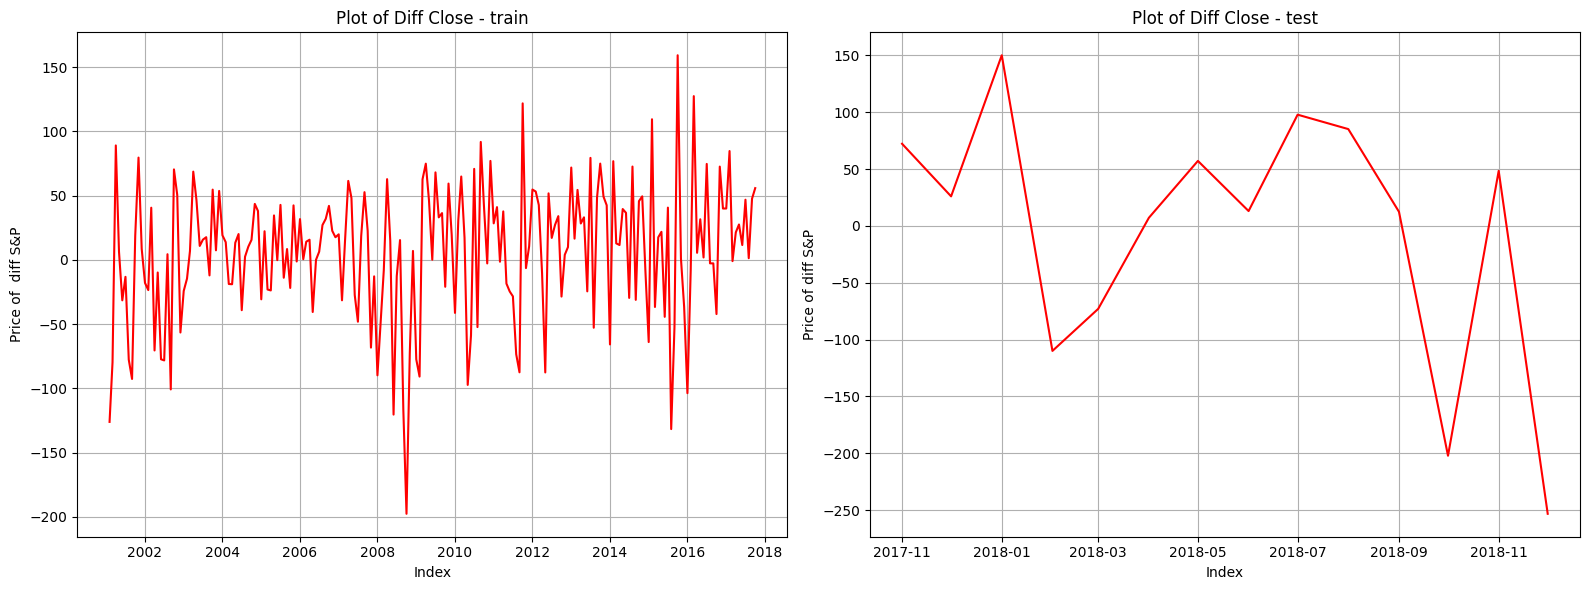

In [333]:
# Create side-by-side plots for first difference of Close prices in train and test sets
fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot train difference of close prices on the left subplot
axs[0].plot(train['close_diff'], color='red')
axs[0].set_title('Plot of Diff Close - train')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Price of  diff S&P')
axs[0].grid(True)

# Plot test difference of close prices on the right subplot
axs[1].plot(test['close_diff'], color='red')
axs[1].set_title('Plot of Diff Close - test')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Price of diff S&P')
axs[1].grid(True)

plt.tight_layout() 
plt.show()

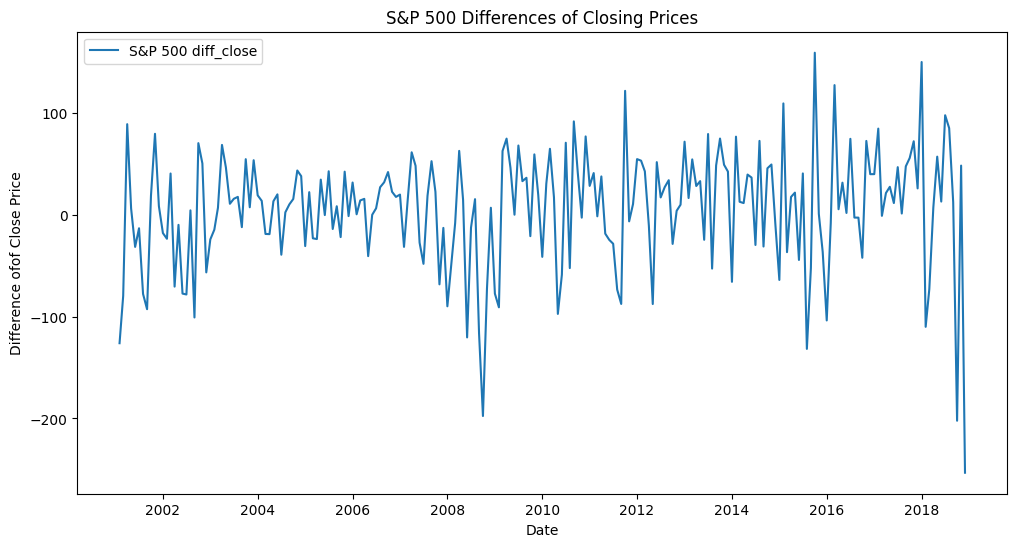

In [334]:
# Plot of first difference of S&P 500 closing prices over time
plt.figure(figsize=(12, 6))  
plt.plot(sp500['Date'], sp500['close_diff'], label='S&P 500 diff_close')  # Plot Date vs Close
plt.xlabel('Date')
plt.ylabel('Difference ofof Close Price')
plt.title('S&P 500 Differences of Closing Prices')
plt.legend()
plt.show()

In [335]:
# Define a function to perform the Augmented Dickey-Fuller (ADF) test on a time series
def adf_test(series, title=''):
    """Perform ADF test with trend and intercept"""
    result = adfuller(series, regression='ct', autolag='AIC')
    output = {
        'Test Statistic': result[0],
        'p-value': result[1],
        'Critical Values': result[4]
    }
    return output

ADF test performed on the whole dataset closing prices.

In [336]:
# Run tests
level = adf_test(sp500['Close'], "Level")
diff = adf_test(pd.Series(sp500['close_diff']).dropna(), "First Difference")

# Create results table
results = pd.DataFrame({
    'Model': ['Trend and intercept', 'Trend and intercept'],
    'Data': ['Level', 'First difference'],
    'Test Statistic': [level['Test Statistic'], diff['Test Statistic']],
    'Probability': [level['p-value'], diff['p-value']]
})

# Format output
print("Table 1. Augmented Dickey-Fuller Test\n")
print(results.to_string(float_format=lambda x: f"{x:.5f}", index=False))

# Add critical values
print("\nCritical Values:")
for key in level['Critical Values']:
    print(f"{key}%: {level['Critical Values'][key]:.5f}")

Table 1. Augmented Dickey-Fuller Test

              Model             Data  Test Statistic  Probability
Trend and intercept            Level        -2.16731      0.50826
Trend and intercept First difference       -13.25297      0.00000

Critical Values:
1%%: -4.00151
5%%: -3.43111
10%%: -3.13916


ADF test performed on the train dataset closing prices.

In [337]:
# Run tests
level = adf_test(train['Close'], "Level")
diff = adf_test(pd.Series(train['close_diff']).dropna(), "First Difference")

# Create results table
results = pd.DataFrame({
    'Model': ['Trend and intercept', 'Trend and intercept'],
    'Data': ['Level', 'First difference'],
    'Test Statistic': [level['Test Statistic'], diff['Test Statistic']],
    'Probability': [level['p-value'], diff['p-value']]
})

# Format output
print("Table 1. Augmented Dickey-Fuller Test\n")
print(results.to_string(float_format=lambda x: f"{x:.5f}", index=False))

# Add critical values
print("\nCritical Values:")
for key in level['Critical Values']:
    print(f"{key}%: {level['Critical Values'][key]:.5f}")

Table 1. Augmented Dickey-Fuller Test

              Model             Data  Test Statistic  Probability
Trend and intercept            Level        -1.42949      0.85205
Trend and intercept First difference       -13.20496      0.00000

Critical Values:
1%%: -4.00453
5%%: -3.43256
10%%: -3.14001


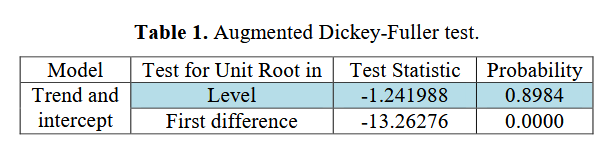

Here we received results similar to those reported in the paper.

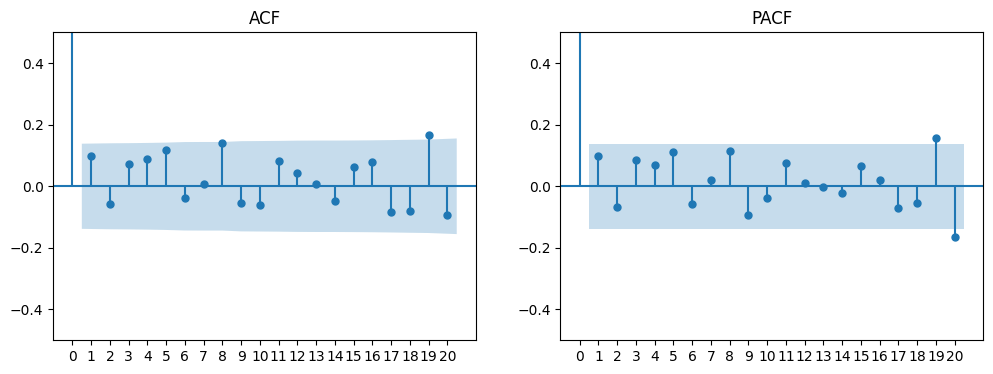

In [338]:
# Plot ACF and PACF of first differenced train 'Close' prices
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(np.array(train['Close'].diff()[1:]), lags=20, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-0.5,0.5])
axes[0].set_xticks(range(0, 21, 1))

# Partial autocorrelation plot
plot_pacf(np.array(train['Close'].diff()[1:]), lags=20, ax=axes[1]) # PACF
axes[1].set_title("PACF")
axes[1].set_ylim([-0.5,0.5])
axes[1].set_xticks(range(0, 21, 1))

plt.show()

The paper lacks ACF/PACF plots for stationary series and has inconsistent figure numbering.

The rationale for selecting the ARIMA(2,1,2) model is unclear, given that the corresponding lags are not statistically significant. 

While alternative lag structures, such as 8 or 19, were considered, their inclusion is impractical due to the limited length of the out-of-sample dataset, which spans only 14 months. 

This constraint restricts the reliability of models with higher lag orders.

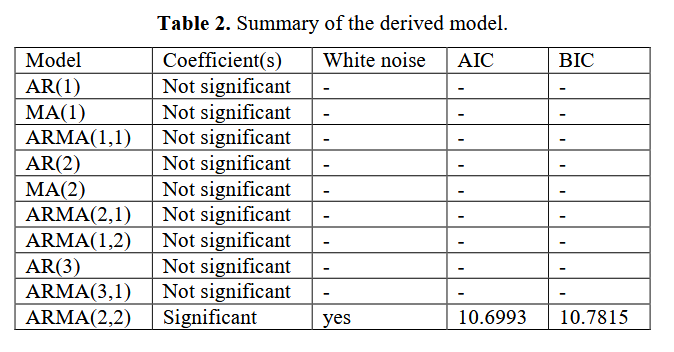

In [339]:
# Fit ARIMA models with different (p, d, q) parameters on training data
ar1 = ARIMA(train['Close'].values, order=(1, 1, 0)).fit()
ma1 = ARIMA(train['Close'].values, order=(0, 1, 1)).fit()
arma11 = ARIMA(train['Close'].values, order=(1, 1, 1)).fit()
ar2 = ARIMA(train['Close'].values, order=(2, 1, 0)).fit()
ma2 = ARIMA(train['Close'].values, order=(0, 1, 2)).fit()
arma21 = ARIMA(train['Close'].values, order=(2, 1, 1)).fit()
arma12 = ARIMA(train['Close'].values, order=(1, 1, 2)).fit()
ar3 = ARIMA(train['Close'].values, order=(3, 1, 0)).fit()
arma31 = ARIMA(train['Close'].values, order=(3, 1, 1)).fit()
arma22 = ARIMA(train['Close'].values, order=(2, 1, 2)).fit()
ar8= ARIMA(train['Close'].values, order=([8], 1, 0)).fit()
ma8= ARIMA(train['Close'].values, order=(0, 1, [8])).fit()
arma88 = ARIMA(train['Close'].values, order=([8], 1, [8])).fit()
ar19= ARIMA(train['Close'].values, order=([19], 1, 0)).fit()
ma19= ARIMA(train['Close'].values, order=(0, 1, [19])).fit()
ar20= ARIMA(train['Close'].values, order=([20], 1, 0)).fit()
ma20= ARIMA(train['Close'].values, order=(0, 1, [20])).fit()


C:\Users\Andrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Andrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [340]:
# List of fitted ARIMA models
models = [ar1, ma1, arma11, ar2, ma2, arma21, arma12, ar3, arma31, arma22, ar8, ma8, arma88, ar19, ma19, ar20, ma20] # list with all the models
names = ['ar1', 'ma1', 'arma11','ar2', 'ma2', 'arma21', 'arma12', 'ar3', 'arma31', 'arma22', 'ar8', 'ma8', 'arma88', 'ar19', 'ma19', 'ar20', 'ma20'] # models' names

# Preparing a DataFrame with models sorted by AIC, BIC
results = []
for model, name in zip(models, names):
    results.append([name, round(model.aic,2), round(model.bic,2)])
results_df = pd.DataFrame(results)
results_df.columns = ['model', 'AIC', 'BIC']

In [341]:
# Display models sorted by AIC
print('Models by AIC:\n',results_df.sort_values('AIC'))

Models by AIC:
      model      AIC      BIC
13    ar19  2161.45  2168.06
14    ma19  2161.96  2168.57
10     ar8  2163.55  2170.15
12  arma88  2164.11  2174.02
9   arma22  2164.14  2180.65
11     ma8  2164.24  2170.85
1      ma1  2165.87  2172.47
0      ar1  2166.21  2172.81
2   arma11  2166.57  2176.48
8   arma31  2166.58  2183.10
15    ar20  2167.17  2173.78
4      ma2  2167.19  2177.10
16    ma20  2167.37  2173.97
3      ar2  2167.58  2177.49
7      ar3  2167.68  2180.89
6   arma12  2168.57  2181.79
5   arma21  2168.57  2181.79


In [342]:
# Display models sorted by BIC 
print('Models by BIC:\n',results_df.sort_values('BIC'))

Models by BIC:
      model      AIC      BIC
13    ar19  2161.45  2168.06
14    ma19  2161.96  2168.57
10     ar8  2163.55  2170.15
11     ma8  2164.24  2170.85
1      ma1  2165.87  2172.47
0      ar1  2166.21  2172.81
15    ar20  2167.17  2173.78
16    ma20  2167.37  2173.97
12  arma88  2164.11  2174.02
2   arma11  2166.57  2176.48
4      ma2  2167.19  2177.10
3      ar2  2167.58  2177.49
9   arma22  2164.14  2180.65
7      ar3  2167.68  2180.89
6   arma12  2168.57  2181.79
5   arma21  2168.57  2181.79
8   arma31  2166.58  2183.10


In [343]:
# Display the summary statistics for the AR(19) model
print(ar19.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  202
Model:              ARIMA([19], 1, 0)   Log Likelihood               -1078.726
Date:                Sun, 25 May 2025   AIC                           2161.453
Time:                        11:44:21   BIC                           2168.059
Sample:                             0   HQIC                          2164.126
                                - 202                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L19         0.1975      0.074      2.654      0.008       0.052       0.343
sigma2      2675.7055    230.431     11.612      0.000    2224.068    3127.343
Ljung-Box (L1) (Q):                   3.85   Jarque-

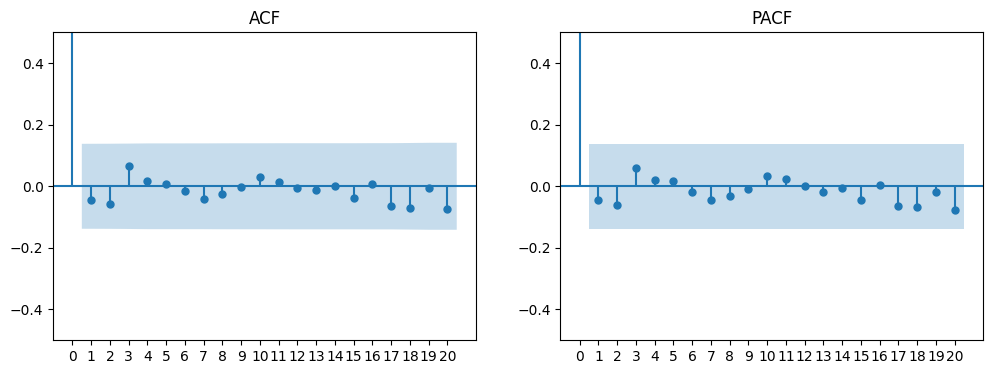

In [344]:
# Plot ACF and PACF of residuals from AR(19) model
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(ar19.resid, lags=20, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-0.5,0.5])
axes[0].set_xticks(range(0, 21, 1))

# Partial autocorrelation plot
plot_pacf(ar19.resid, lags=20, ax=axes[1]) # PACF
axes[1].set_title("PACF")
axes[1].set_ylim([-0.5,0.5])
axes[1].set_xticks(range(0, 21, 1))

plt.show()

In [345]:
# Display the summary statistics for the AR(8) model
print(ar8.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  202
Model:               ARIMA([8], 1, 0)   Log Likelihood               -1079.773
Date:                Sun, 25 May 2025   AIC                           2163.546
Time:                        11:44:21   BIC                           2170.153
Sample:                             0   HQIC                          2166.220
                                - 202                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L8          0.1639      0.073      2.259      0.024       0.022       0.306
sigma2      2710.3980    251.710     10.768      0.000    2217.055    3203.741
Ljung-Box (L1) (Q):                   2.44   Jarque-

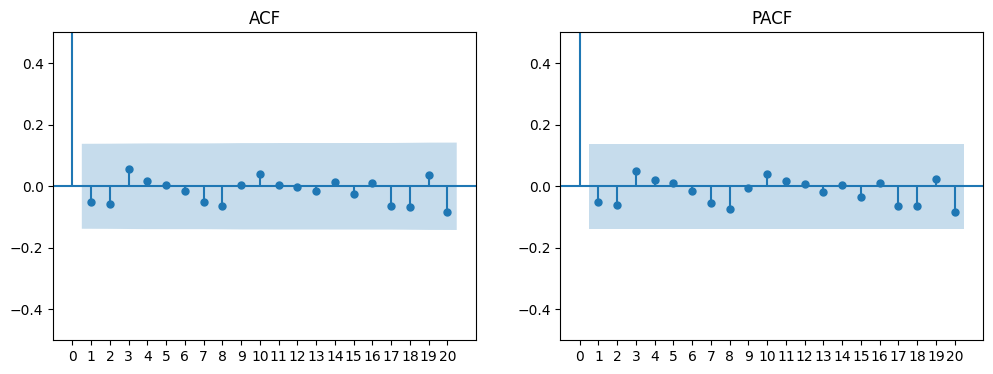

In [346]:
# Plot ACF and PACF of residuals from AR(8) model
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(ar8.resid, lags=20, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-0.5,0.5])
axes[0].set_xticks(range(0, 21, 1))

# Partial autocorrelation plot
plot_pacf(ar8.resid, lags=20, ax=axes[1]) # PACF
axes[1].set_title("PACF")
axes[1].set_ylim([-0.5,0.5])
axes[1].set_xticks(range(0, 21, 1))

plt.show()

Although AIC and BIC suggest that models like AR(19) may perform better than ARMA(2,2) which was presented as the best in the paper, this is not reasonable because the out-of-sample dataset contains only 14 observations. Including 19 lags in such a small sample does not make sense.

Even considering ARMA(2,2), EViews results differ significantly in AIC/BIC and constant terms because they used I(1) data. 

Since ARIMA differencing removes the mean, no constant is needed—adding one implies a trend in the original series. 

We tried various optimizers and software; while EViews results similar to theirs, Python and Gretl gave different outcomes we couldn’t replicate.

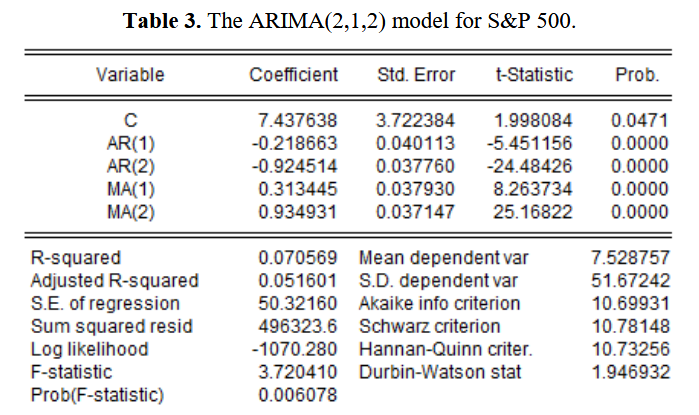

In [347]:
# Display the summary statistics for the AR(8) model
print(arma22.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  202
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1077.068
Date:                Sun, 25 May 2025   AIC                           2164.135
Time:                        11:44:21   BIC                           2180.652
Sample:                             0   HQIC                          2170.819
                                - 202                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0142      0.107      0.132      0.895      -0.196       0.224
ar.L2          0.8559      0.092      9.296      0.000       0.675       1.036
ma.L1          0.1188      0.859      0.138      0.8

We decided to split the data with train for 80% and test for 20% and estimate ARIMA model.

In [348]:
# Assuming sp500 is sorted by date in ascending order
train_size = int(len(sp500) * 0.8)

train_df = sp500.iloc[:train_size]
test_df = sp500.iloc[train_size:]

In [349]:
# Check the dimensions of the training dataset (rows, columns)
train_df.shape

(172, 7)

In [350]:
# Check the dimensions of the training dataset (rows, columns)
test_df.shape

(44, 7)

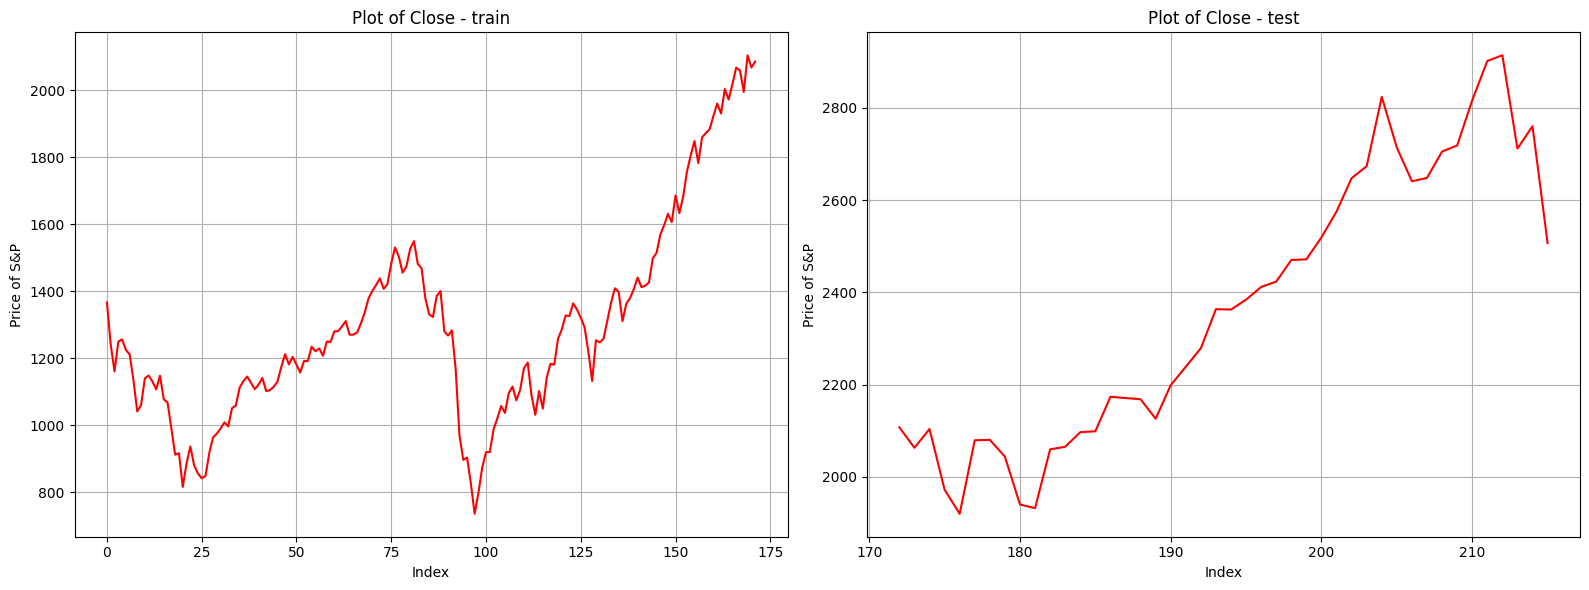

In [351]:
# Create side-by-side plots for training and test closing prices
fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot train difference of close prices on the left subplot
axs[0].plot(train_df['Close'], color='red')
axs[0].set_title('Plot of Close - train')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Price of S&P')
axs[0].grid(True)

# Plot test difference of close prices on the right subplot
axs[1].plot(test_df['Close'], color='red')
axs[1].set_title('Plot of Close - test')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Price of S&P')
axs[1].grid(True)

plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()



In [352]:
# Run tests
level = adf_test(train_df['Close'], "Level")
diff = adf_test(pd.Series(train_df['close_diff']).dropna(), "First Difference")

# Create results table
results = pd.DataFrame({
    'Model': ['Trend and intercept', 'Trend and intercept'],
    'Data': ['Level', 'First difference'],
    'Test Statistic': [level['Test Statistic'], diff['Test Statistic']],
    'Probability': [level['p-value'], diff['p-value']]
})

# Format output
print("Table 1. Augmented Dickey-Fuller Test\n")
print(results.to_string(float_format=lambda x: f"{x:.5f}", index=False))

# Add critical values
print("\nCritical Values:")
for key in level['Critical Values']:
    print(f"{key}%: {level['Critical Values'][key]:.5f}")

Table 1. Augmented Dickey-Fuller Test

              Model             Data  Test Statistic  Probability
Trend and intercept            Level        -1.41746      0.85571
Trend and intercept First difference       -11.90306      0.00000

Critical Values:
1%%: -4.01271
5%%: -3.43648
10%%: -3.14231


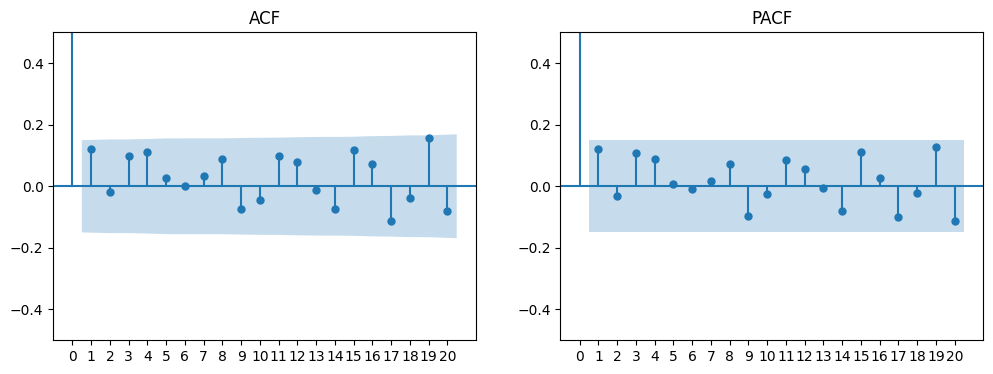

In [353]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(np.array(train_df['Close'].diff()[1:]), lags=20, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-0.5,0.5])
axes[0].set_xticks(range(0, 21, 1))

# Partial autocorrelation plot
plot_pacf(np.array(train_df['Close'].diff()[1:]), lags=20, ax=axes[1]) # PACF
axes[1].set_title("PACF")
axes[1].set_ylim([-0.5,0.5])
axes[1].set_xticks(range(0, 21, 1))

plt.show()

We see that it is montlhly data is probably white noise; no significant autocorrelation; so maybe ARIMA is not the best approach for such type of data; since SP500 monthly data is too wide

In [354]:
# Fit various ARIMA models with different (p,d,q) orders on training data
arma00 = ARIMA(train_df['Close'].values, order=(0, 1, 0)).fit()
ar1 = ARIMA(train_df['Close'].values, order=(1, 1, 0)).fit()
ma1 = ARIMA(train_df['Close'].values, order=(0, 1, 1)).fit()
arma11 = ARIMA(train_df['Close'].values, order=(1, 1, 1)).fit()
ar2 = ARIMA(train_df['Close'].values, order=(2, 1, 0)).fit()
ma2 = ARIMA(train_df['Close'].values, order=(0, 1, 2)).fit()
arma21 = ARIMA(train_df['Close'].values, order=(2, 1, 1)).fit()
arma12 = ARIMA(train_df['Close'].values, order=(1, 1, 2)).fit()
arma22 = ARIMA(train_df['Close'].values, order=(2, 1, 2)).fit()


C:\Users\Andrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Andrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [355]:
# Evaluate and compare ARMA models by AIC and BIC
models = [arma00, ar1, ma1, arma11, ar2, ma2, arma21, arma12, arma22] # list with all the models
names = ['arma00', 'ar1', 'ma1', 'arma11','ar2', 'ma2', 'arma21', 'arma12', 'arma22'] # models' names

# Preparing a DataFrame with models sorted by AIC, BIC
results = []
for model, name in zip(models, names):
    results.append([name, round(model.aic,2), round(model.bic,2)])
results_df = pd.DataFrame(results)
results_df.columns = ['model', 'AIC', 'BIC']

In [356]:
# Sort and display models by lowest AIC values
print('Models by AIC:\n',results_df.sort_values('AIC'))

Models by AIC:
     model      AIC      BIC
2     ma1  1832.43  1838.72
1     ar1  1832.61  1838.89
0  arma00  1833.45  1836.60
3  arma11  1834.17  1843.60
5     ma2  1834.30  1843.73
4     ar2  1834.51  1843.93
7  arma12  1834.91  1847.48
8  arma22  1836.13  1851.84
6  arma21  1836.17  1848.73


In [357]:
# Sort and display models by lowest BIC values
print('Models by BIC:\n',results_df.sort_values('BIC'))

Models by BIC:
     model      AIC      BIC
0  arma00  1833.45  1836.60
2     ma1  1832.43  1838.72
1     ar1  1832.61  1838.89
3  arma11  1834.17  1843.60
5     ma2  1834.30  1843.73
4     ar2  1834.51  1843.93
7  arma12  1834.91  1847.48
6  arma21  1836.17  1848.73
8  arma22  1836.13  1851.84


The ARIMA model does not capture all dynamics and is likely not suitable for data at this frequency. 

Interestingly, the AR(0,0) model performs better, suggesting that the process may resemble white noise. And it makes no sense to test in on out-of-sample set.

In [358]:
# Summary of ARMA(0,0)
print(arma00.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  172
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -915.727
Date:                Sun, 25 May 2025   AIC                           1833.455
Time:                        11:44:23   BIC                           1836.597
Sample:                             0   HQIC                          1834.730
                                - 172                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2623.8259    251.714     10.424      0.000    2130.475    3117.176
Ljung-Box (L1) (Q):                   2.53   Jarque-Bera (JB):                18.45
Prob(Q):                              0.11   Pr

In [359]:
# Summary of AR(1)
print(ar1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  172
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -914.305
Date:                Sun, 25 May 2025   AIC                           1832.610
Time:                        11:44:23   BIC                           1838.893
Sample:                             0   HQIC                          1835.159
                                - 172                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1304      0.065      1.999      0.046       0.003       0.258
sigma2      2579.5884    254.356     10.142      0.000    2081.060    3078.116
Ljung-Box (L1) (Q):                   0.01   Jarque-

In [360]:
# Summary of MA(1)
print(ma1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  172
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -914.217
Date:                Sun, 25 May 2025   AIC                           1832.435
Time:                        11:44:23   BIC                           1838.718
Sample:                             0   HQIC                          1834.984
                                - 172                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1396      0.066      2.108      0.035       0.010       0.269
sigma2      2576.9432    256.466     10.048      0.000    2074.279    3079.607
Ljung-Box (L1) (Q):                   0.03   Jarque-

The paper used an ARMA model for the mean equation, but it seems incorrectly specified and estimated. 

For reference, we prepared data for GARCH modeling and created returns to plot the fitted distribution of log returns.

In [361]:
# Calculate daily returns as the difference of Close prices, dropping missing values
returns = train['Close'].diff().dropna() 

In [362]:
# Check the dimensions of the training dataset (rows, columns)
train_df.shape

(172, 7)

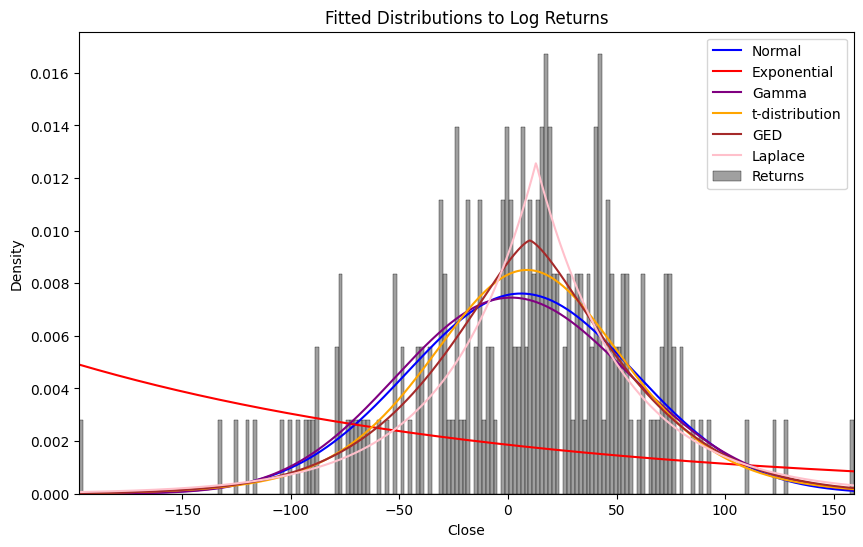

In [363]:
# Fit multiple distributions to the returns data and plot their PDFs over the returns histogram
params_normal = norm.fit(returns)
params_expon = expon.fit(returns)
params_gamma = gamma.fit(returns)
params_t = t.fit(returns)
params_ged = gennorm.fit(returns)
params_laplace = laplace.fit(returns)

lower_limit = returns.min()
upper_limit = returns.max()
x = np.linspace(lower_limit, upper_limit, 1000)

pdf_normal = norm.pdf(x, *params_normal)
pdf_expon = expon.pdf(x, *params_expon)
pdf_gamma = gamma.pdf(x, *params_gamma)
pdf_t = t.pdf(x, *params_t)
pdf_ged = gennorm.pdf(x, *params_ged)
pdf_laplace = laplace.pdf(x, *params_laplace)

plt.figure(figsize=(10, 6))
sns.histplot(returns, kde=False, bins=200, stat='density', color='gray', label='Returns')  
plt.plot(x, pdf_normal, label='Normal', color='blue')
plt.plot(x, pdf_expon, label='Exponential', color='red')
plt.plot(x, pdf_gamma, label='Gamma', color='purple')
plt.plot(x, pdf_t, label='t-distribution', color='orange')
plt.plot(x, pdf_ged, label='GED', color='brown')
plt.plot(x, pdf_laplace, label='Laplace', color='pink')
plt.xlim(lower_limit, upper_limit)
plt.title('Fitted Distributions to Log Returns')
plt.legend()
plt.show()



There are insufficient observations to properly fit a GARCH model. 

In our case, we only have around 170 observations, which falls short of the recommended minimum sample size for reliable estimation. 

According to studies, a larger sample—typically at least 250 to 500 observations—is needed to ensure stable and accurate GARCH parameter estimates (Ng & Lam, 2006; Lumsdaine, 2009).

### References:  

- Ng, S., & Lam, K. (2006). How does Sample Size Affect GARCH Models? 

    Link: https://www.researchgate.net/publication/221556756_How_does_Sample_Size_Affect_GARCH_Models

- Lumsdaine, R. L. (2009). Small Sample Properties of GARCH Estimates and Persistence. 

    Link: https://www.researchgate.net/publication/24080536_Small_Sample_Properties_of_GARCH_Estimates_and_Persistence

### Conclusion

Possible challenges:

- Not enough observations for reliable model estimation.  
- Lack of clear comments or details on model specifications.  
- EVIEWS uses different optimizers that cannot be exactly replicated in Python.  
- Confusion or mixing up of ARMA and ARIMA models in the literature review and throughout the analysis process.
